In [34]:
import pandas as pd
import os
from datetime import datetime

def load_and_concatenate_csv(folder_path):
    all_data = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            try:
                df = pd.read_csv(file_path)
                df.columns = df.columns.str.strip()  # 공백 제거

                # 열 이름 체크
                if 'Auto Id' not in df.columns:
                    raise ValueError(f"[오류] {file}에 'AutoId' 열이 없습니다.")

                if 'Time' not in df.columns:
                    raise ValueError(f"[오류] {file}에 'Time' 열이 없습니다.")

                # 날짜 추출
                date_str = ''.join(filter(str.isdigit, file))[:8]
                date_base = pd.to_datetime(date_str, format='%Y%m%d')

                # DateTime 생성
                df['Time'] = df['Time'].astype(str).str.strip()
                df['DateTime'] = pd.to_datetime(date_base.strftime('%Y-%m-%d') + ' ' + df['Time'], errors='coerce')

                # 유효한 DateTime만 유지
                df = df[df['DateTime'].notna()].copy()
                all_data.append(df)
            except Exception as e:
                print(f"파일 무시됨: {file}, 오류: {e}")
    if not all_data:
        raise RuntimeError("유효한 데이터를 가진 CSV 파일이 없습니다.")
    return pd.concat(all_data, ignore_index=True)

def get_longest_off_period(data, auto_id):
    if 'Auto Id' not in data.columns:
        raise KeyError("'AutoId' 열이 존재하지 않습니다.")
    
    df = data[data['Auto Id'] == auto_id].copy()
    if df.empty:
        print(f"[경고] 지정한 AutoId={auto_id}에 해당하는 데이터가 없습니다.")
        return pd.DataFrame()

    df = df.sort_values('DateTime')  # 정확한 시계열 정렬
    df['is_off'] = df['Frun'] == 0

    # 연속 OFF 그룹 라벨링
    df['gap'] = (df['DateTime'].diff() != pd.Timedelta(seconds=5)) | (~df['is_off'])  # 5초 간격 기준
    df['off_group'] = df['gap'].cumsum()

    # 가장 긴 OFF 구간 선택
    off_df = df[df['is_off']].copy()
    off_groups = off_df.groupby('off_group')
    if off_groups.ngroups == 0:
        print("OFF 구간이 존재하지 않습니다.")
        return pd.DataFrame()

    longest_group = max(off_groups, key=lambda x: len(x[1]))
    longest_df = longest_group[1].copy()

    # 구간 정보 출력
    start_time = longest_df['DateTime'].iloc[0]
    end_time = longest_df['DateTime'].iloc[-1]
    duration = end_time - start_time
    print(f"[INFO] Auto Id={auto_id}의 가장 긴 OFF 구간: {start_time} ~ {end_time} ({duration})")

    return longest_df[['DateTime', 'Tid', 'Tod', 'Hid', 'Hod']]



In [40]:
if __name__ == "__main__":
    folder_path = '/home/deok/Desktop/LOG_SMART_202407'  # ← CSV 폴더 경로 지정
    auto_id = 2                                         # ← 분석할 AutoId 지정

    all_data = load_and_concatenate_csv(folder_path)
    longest_off_data = get_longest_off_period(all_data, auto_id)

    if not longest_off_data.empty:
        longest_off_data.to_csv(f'longest_off_period_timeseries_{auto_id}.csv', index=False)

파일 무시됨: LOG_SMARTCARE_20240704.csv, 오류: Error tokenizing data. C error: Expected 73 fields in line 70310, saw 119

[INFO] Auto Id=2의 가장 긴 OFF 구간: 2024-07-05 23:05:01 ~ 2024-07-07 15:40:21 (1 days 16:35:20)


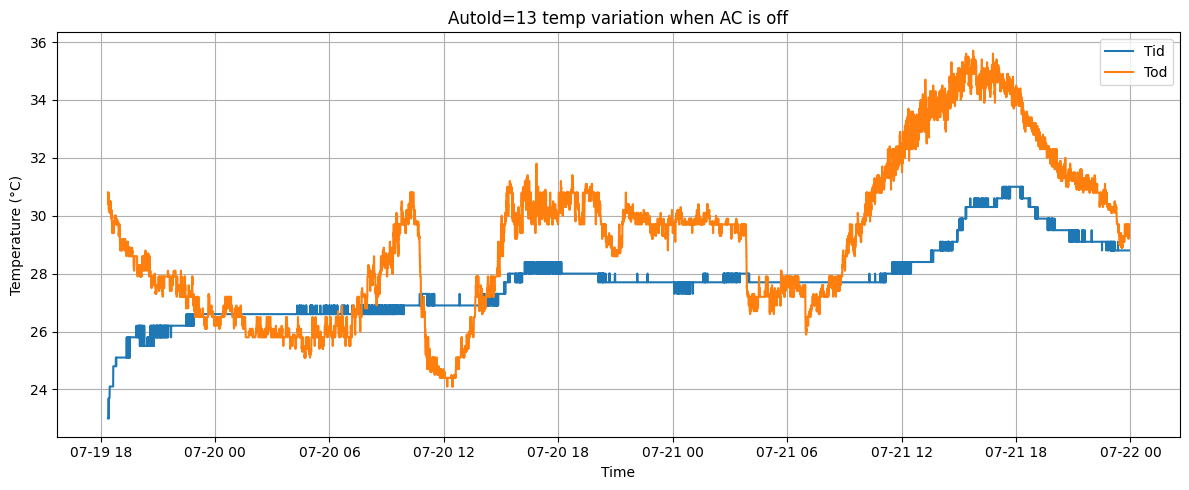

In [44]:
!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt

auto_id = 13
# 저장된 파일 불러오기 (또는 longest_off_data 직접 사용 가능)
df = pd.read_csv(f'longest_off_period_timeseries_{auto_id}.csv')

# DateTime이 문자열일 경우 datetime 형식으로 변환
df['DateTime'] = pd.to_datetime(df['DateTime'])

# 플롯
plt.figure(figsize=(12, 5))
plt.plot(df['DateTime'], df['Tid'], label='Tid', color='tab:blue')
plt.plot(df['DateTime'], df['Tod'], label='Tod', color='tab:orange')

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'AutoId={auto_id} temp variation when AC is off')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


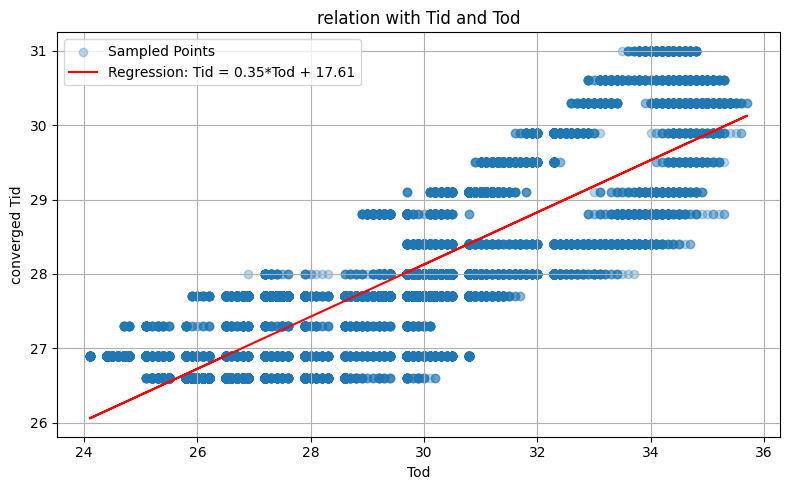


✅ 회귀식: Tid ≈ 0.351 * Tod + 17.612


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# ✅ 분석할 CSV 파일 이름 지정 및 읽기
csv_file = 'longest_off_period_timeseries_13.csv'   # ← 여기에 원하는 파일명을 입력하세요
df = pd.read_csv(csv_file, parse_dates=['DateTime'])  # DateTime 파싱 포함

# 1. 에어컨 꺼진 시점 이후의 데이터만 필터
df_filtered = df[(df['DateTime'] >= '2024-07-20 00:00:00')].copy()

# 2. Tid 수렴 구간 검출 (추가 추천 로직)
## df_filtered['Tid_rolling_std'] = df_filtered['Tid'].rolling(window=12, center=True).std()
## stable_df = df_filtered[df_filtered['Tid_rolling_std'] < 0.15].dropna()

# 4. Tod vs Tid 산점도
plt.figure(figsize=(8,5))
plt.scatter(df_filtered['Tod'], df_filtered['Tid'], alpha=0.3, label='Sampled Points')
plt.xlabel('Tod')
plt.ylabel('converged Tid')
plt.title('relation with Tid and Tod')
plt.grid(True)

# 5. 선형 회귀
X = df_filtered['Tod'].values.reshape(-1, 1)
y = df_filtered['Tid'].values
model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_
plt.plot(X, model.predict(X), color='red', label=f'Regression: Tid = {slope:.2f}*Tod + {intercept:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n✅ 회귀식: Tid_cov ≈ {slope:.3f} * Tod + {intercept:.3f}")



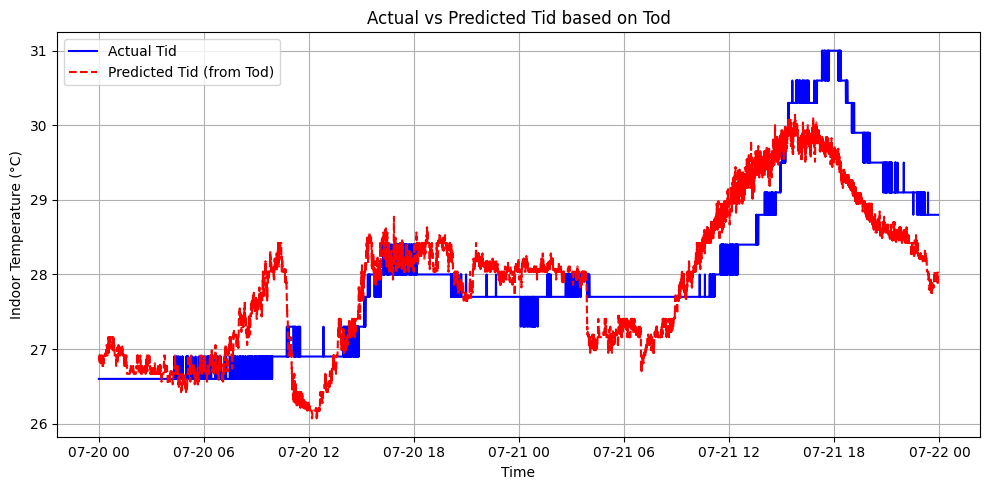

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. CSV 파일 읽기
csv_file = 'longest_off_period_timeseries_13.csv'
df = pd.read_csv(csv_file, parse_dates=['DateTime'])

# 2. 7월 20일 이후 데이터 필터링
df_filtered = df[(df['DateTime'] >= '2024-07-20 00:00:00')].copy()

# 3. 회귀식 기반 예측값 계산
slope = 0.351
intercept = 17.612
df_filtered['Tid_pred'] = slope * df_filtered['Tod'] + intercept

# 4. 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_filtered['DateTime'], df_filtered['Tid'], label='Actual Tid', color='blue')
plt.plot(df_filtered['DateTime'], df_filtered['Tid_pred'], label='Predicted Tid (from Tod)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Indoor Temperature (°C)')
plt.title('Actual vs Predicted Tid based on Tod')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ RMSE (Actual vs Predicted Tid): 0.577 °C


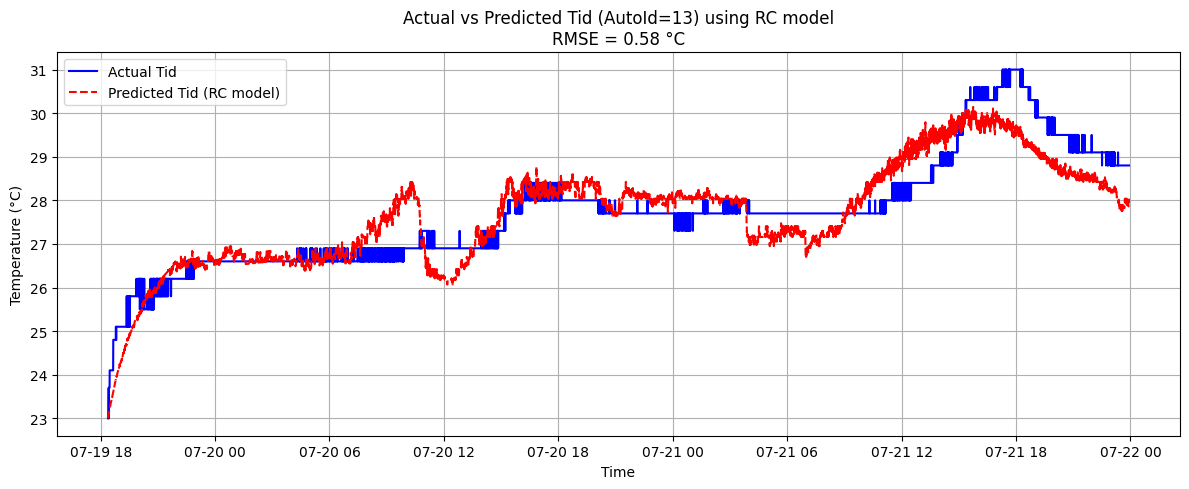

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. 파일 불러오기 (전체 에어컨 OFF 기간)
csv_file = 'longest_off_period_timeseries_13.csv'
df = pd.read_csv(csv_file, parse_dates=['DateTime'])

# 2. 시간 기준 설정
df['t_sec'] = (df['DateTime'] - df['DateTime'].iloc[0]).dt.total_seconds()

# 3. 초기 내부 온도
T0 = df['Tid'].iloc[0]

# 4. 추정된 시정수 tau (초)
tau = 7806.44  # ≈ 255.2분

# 5. 회귀식 기반으로 각 시간의 T_inf 계산
df['T_inf'] = 0.351 * df['Tod'] + 17.612

# 6. RC 모델로 Tid 예측값 계산
df['Tid_pred'] = df['T_inf'] + (T0 - df['T_inf']) * np.exp(-df['t_sec'] / tau)

# ✅ RMSE 계산
rmse = np.sqrt(mean_squared_error(df['Tid'], df['Tid_pred']))
print(f"✅ RMSE (Actual vs Predicted Tid): {rmse:.3f} °C")

# 7. 그래프 플로팅
plt.figure(figsize=(12, 5))
plt.plot(df['DateTime'], df['Tid'], label='Actual Tid', color='blue')
plt.plot(df['DateTime'], df['Tid_pred'], label='Predicted Tid (RC model)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Actual vs Predicted Tid (AutoId=13) using RC model\nRMSE = {rmse:.2f} °C')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




✅ 커브핏 기반 추정된 시정수 tau: 7806.44초 ≈ 130.11분


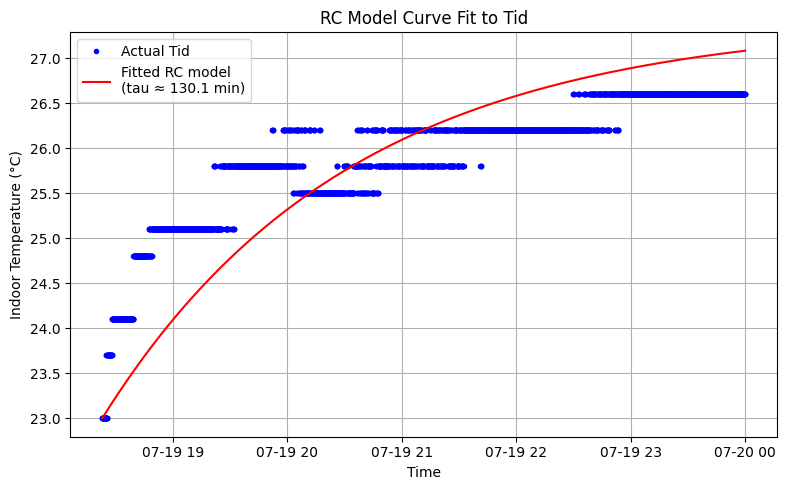

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 데이터 불러오기
df = pd.read_csv('longest_off_period_timeseries_13.csv', parse_dates=['DateTime'])

# 분석 구간 (에어컨 꺼진 직후 구간)
df_segment = df[(df['DateTime'] >= '2024-07-19 18:00:00') & 
                (df['DateTime'] < '2024-07-20 00:00:00')].copy()

# 초기 온도
T0 = df_segment['Tid'].iloc[0]

# 외기온 평균 → 회귀식으로 Tinf 추정
Tod_mean = df_segment['Tod'].mean()
Tinf = 0.351 * Tod_mean + 17.612

# 시간 (초)
df_segment['t_sec'] = (df_segment['DateTime'] - df_segment['DateTime'].iloc[0]).dt.total_seconds()

# 피팅 대상: 시간-온도 데이터
t = df_segment['t_sec'].values
Tid = df_segment['Tid'].values

# RC 모델 수식 정의: T(t) = T_inf + (T0 - T_inf) * exp(-t / tau)
def rc_model(t, tau):
    return Tinf + (T0 - Tinf) * np.exp(-t / tau)

# curve_fit 수행
popt, _ = curve_fit(rc_model, t, Tid, p0=[5000])  # 초기 추정값 5000초
tau_est = popt[0]

# 결과 출력
print(f"✅ 커브핏 기반 추정된 시정수 tau: {tau_est:.2f}초 ≈ {tau_est/60:.2f}분")

# 예측 곡선
Tid_fit = rc_model(t, tau_est)

# 시각화
plt.figure(figsize=(8,5))
plt.plot(df_segment['DateTime'], Tid, 'b.', label='Actual Tid')
plt.plot(df_segment['DateTime'], Tid_fit, 'r-', label=f'Fitted RC model\n(tau ≈ {tau_est/60:.1f} min)')
plt.xlabel('Time')
plt.ylabel('Indoor Temperature (°C)')
plt.title('RC Model Curve Fit to Tid')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 외기온 변화에 실내온도 반응이 적은 이유

외기온를 잘 따라가는 구간에 비해 습도가 10정도 높았음 해당 날짜에 강수량 존재, 잘따라가는 날에는 비 안옴